7275 - Project 2 Notebook - Group 3


Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical tests
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Loading the data

In [ ]:
df = pd.read_csv('nvda_raw_data.csv')

# Initial inspection
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print("\nData types:")
print(df.head())
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Shape: (2514, 6)

First few rows:
         Date Close/Last     Volume     Open      High        Low
0  12/05/2025    $182.41  143971100  $183.89   $184.66    $180.91
1  12/04/2025    $183.38  167364900  $181.62  $184.515    $179.96
2  12/03/2025    $179.59  165138000  $181.08   $182.45  $179.1101
3  12/02/2025    $181.46  182632200  $181.76   $185.66    $180.00
4  12/01/2025    $179.92  188131000  $174.76   $180.30    $173.68

Data types:
Date          object
Close/Last    object
Volume         int64
Open          object
High          object
Low           object
dtype: object

Basic statistics:
             Volume
count  2.514000e+03
mean   4.585947e+08
std    2.560607e+08
min    5.244924e+07
25%    2.935183e+08
50%    4.101194e+08
75%    5.592553e+08
max    3.688132e+09

Missing values:
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


Data Preprocessing

In [ ]:
def preprocess_nvda_data(df):
    """
    Preprocess NVIDIA stock data for time series analysis
    """
    # Create a copy
    df_clean = df.copy()
    
    # Parse date column - handle the MM/DD/YYYY format
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y')
    
    # Sort by date (ascending for time series)
    df_clean = df_clean.sort_values('Date')
    
    # Set date as index
    df_clean.set_index('Date', inplace=True)
    
    # Clean price columns (remove $ and convert to float)
    price_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in price_columns:
        if col in df_clean.columns:
            # Remove $ sign and convert to float
            df_clean[col] = df_clean[col].str.replace('$', '').str.replace(',', '').astype(float)
    
    # Ensure Volume is numeric
    df_clean['Volume'] = pd.to_numeric(df_clean['Volume'], errors='coerce')
    
    # Create additional features for analysis
    df_clean['Daily_Return'] = df_clean['Close/Last'].pct_change()
    df_clean['Log_Return'] = np.log(df_clean['Close/Last'] / df_clean['Close/Last'].shift(1))
    df_clean['Volatility'] = df_clean['Daily_Return'].rolling(window=20).std()
    
    # Moving averages
    df_clean['MA_5'] = df_clean['Close/Last'].rolling(window=5).mean()
    df_clean['MA_20'] = df_clean['Close/Last'].rolling(window=20).mean()
    df_clean['MA_50'] = df_clean['Close/Last'].rolling(window=50).mean()
    df_clean['MA_200'] = df_clean['Close/Last'].rolling(window=200).mean()
    
    # Volume moving average
    df_clean['Volume_MA'] = df_clean['Volume'].rolling(window=20).mean()
    
    # Price spreads
    df_clean['High_Low_Spread'] = df_clean['High'] - df_clean['Low']
    df_clean['High_Low_Pct'] = (df_clean['High'] - df_clean['Low']) / df_clean['Close/Last']
    df_clean['Open_Close_Spread'] = df_clean['Close/Last'] - df_clean['Open']
    
    # Technical indicators
    df_clean['RSI'] = calculate_rsi(df_clean['Close/Last'])
    df_clean['Upper_Band'], df_clean['Lower_Band'] = calculate_bollinger_bands(df_clean['Close/Last'])
    
    return df_clean

def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, period=20, num_std=2):
    """Calculate Bollinger Bands"""
    sma = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

# Process the data
df_clean = preprocess_nvda_data(df)

print("Preprocessed data shape:", df_clean.shape)
print("\nDate range:", df_clean.index.min(), "to", df_clean.index.max())
print("\nNumber of trading days:", len(df_clean))
print("\nNew features created:")
print(df_clean.columns.tolist())


Preprocessed data shape: (2514, 19)

Date range: 2015-12-08 00:00:00 to 2025-12-05 00:00:00

Number of trading days: 2514

New features created:
['Close/Last', 'Volume', 'Open', 'High', 'Low', 'Daily_Return', 'Log_Return', 'Volatility', 'MA_5', 'MA_20', 'MA_50', 'MA_200', 'Volume_MA', 'High_Low_Spread', 'High_Low_Pct', 'Open_Close_Spread', 'RSI', 'Upper_Band', 'Lower_Band']


In [8]:
df_clean

,Close/Last,Volume,Open,High,Low,Daily_Return,Log_Return,Volatility,MA_5,MA_20,MA_50,MA_200,Volume_MA,High_Low_Spread,High_Low_Pct,Open_Close_Spread,RSI,Upper_Band,Lower_Band,Year,Month
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-08,0.8390,314481160,0.8175,0.8425,0.8123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0302,0.035995,0.0215,NaN,NaN,NaN,2015,12
2015-12-09,0.8178,372674840,0.8388,0.8438,0.8093,-0.025268,-0.025593,NaN,NaN,NaN,NaN,NaN,NaN,0.0345,0.042186,-0.0210,NaN,NaN,NaN,2015,12
2015-12-10,0.8245,236515080,0.8203,0.8290,0.8175,0.008193,0.008159,NaN,NaN,NaN,NaN,NaN,NaN,0.0115,0.013948,0.0042,NaN,NaN,NaN,2015,12
2015-12-11,0.8123,227301520,0.8163,0.8220,0.8105,-0.014797,-0.014907,NaN,NaN,NaN,NaN,NaN,NaN,0.0115,0.014157,-0.0040,NaN,NaN,NaN,2015,12
2015-12-14,0.8143,276209760,0.8130,0.8188,0.8045,0.002462,0.002459,NaN,0.82158,NaN,NaN,NaN,NaN,0.0143,0.017561,0.0013,NaN,NaN,NaN,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-01,179.9200,188131000,174.7600,180.3000,173.6800,0.016497,0.016363,0.026970,179.51000,187.5800,186.8948,153.89115,217413965.0,6.6200,0.036794,5.1600,32.737773,203.948809,171.211191,2025,12
2025-12-02,181.4600,182632200,181.7600,185.6600,180.0000,0.008559,0.008523,0.026427,179.29200,186.3090,186.8518,154.10420,217532210.0,5.6600,0.031191,-0.3000,38.542891,200.114877,172.503123,2025,12
2025-12-03,179.5900,165138000,181.0800,182.4500,179.1101,-0.010305,-0.010359,0.025266,179.64600,185.3540,186.8750,154.30515,216343145.0,3.3399,0.018597,-1.4900,36.412316,198.160050,172.547950,2025,12


EDA - Visualizations

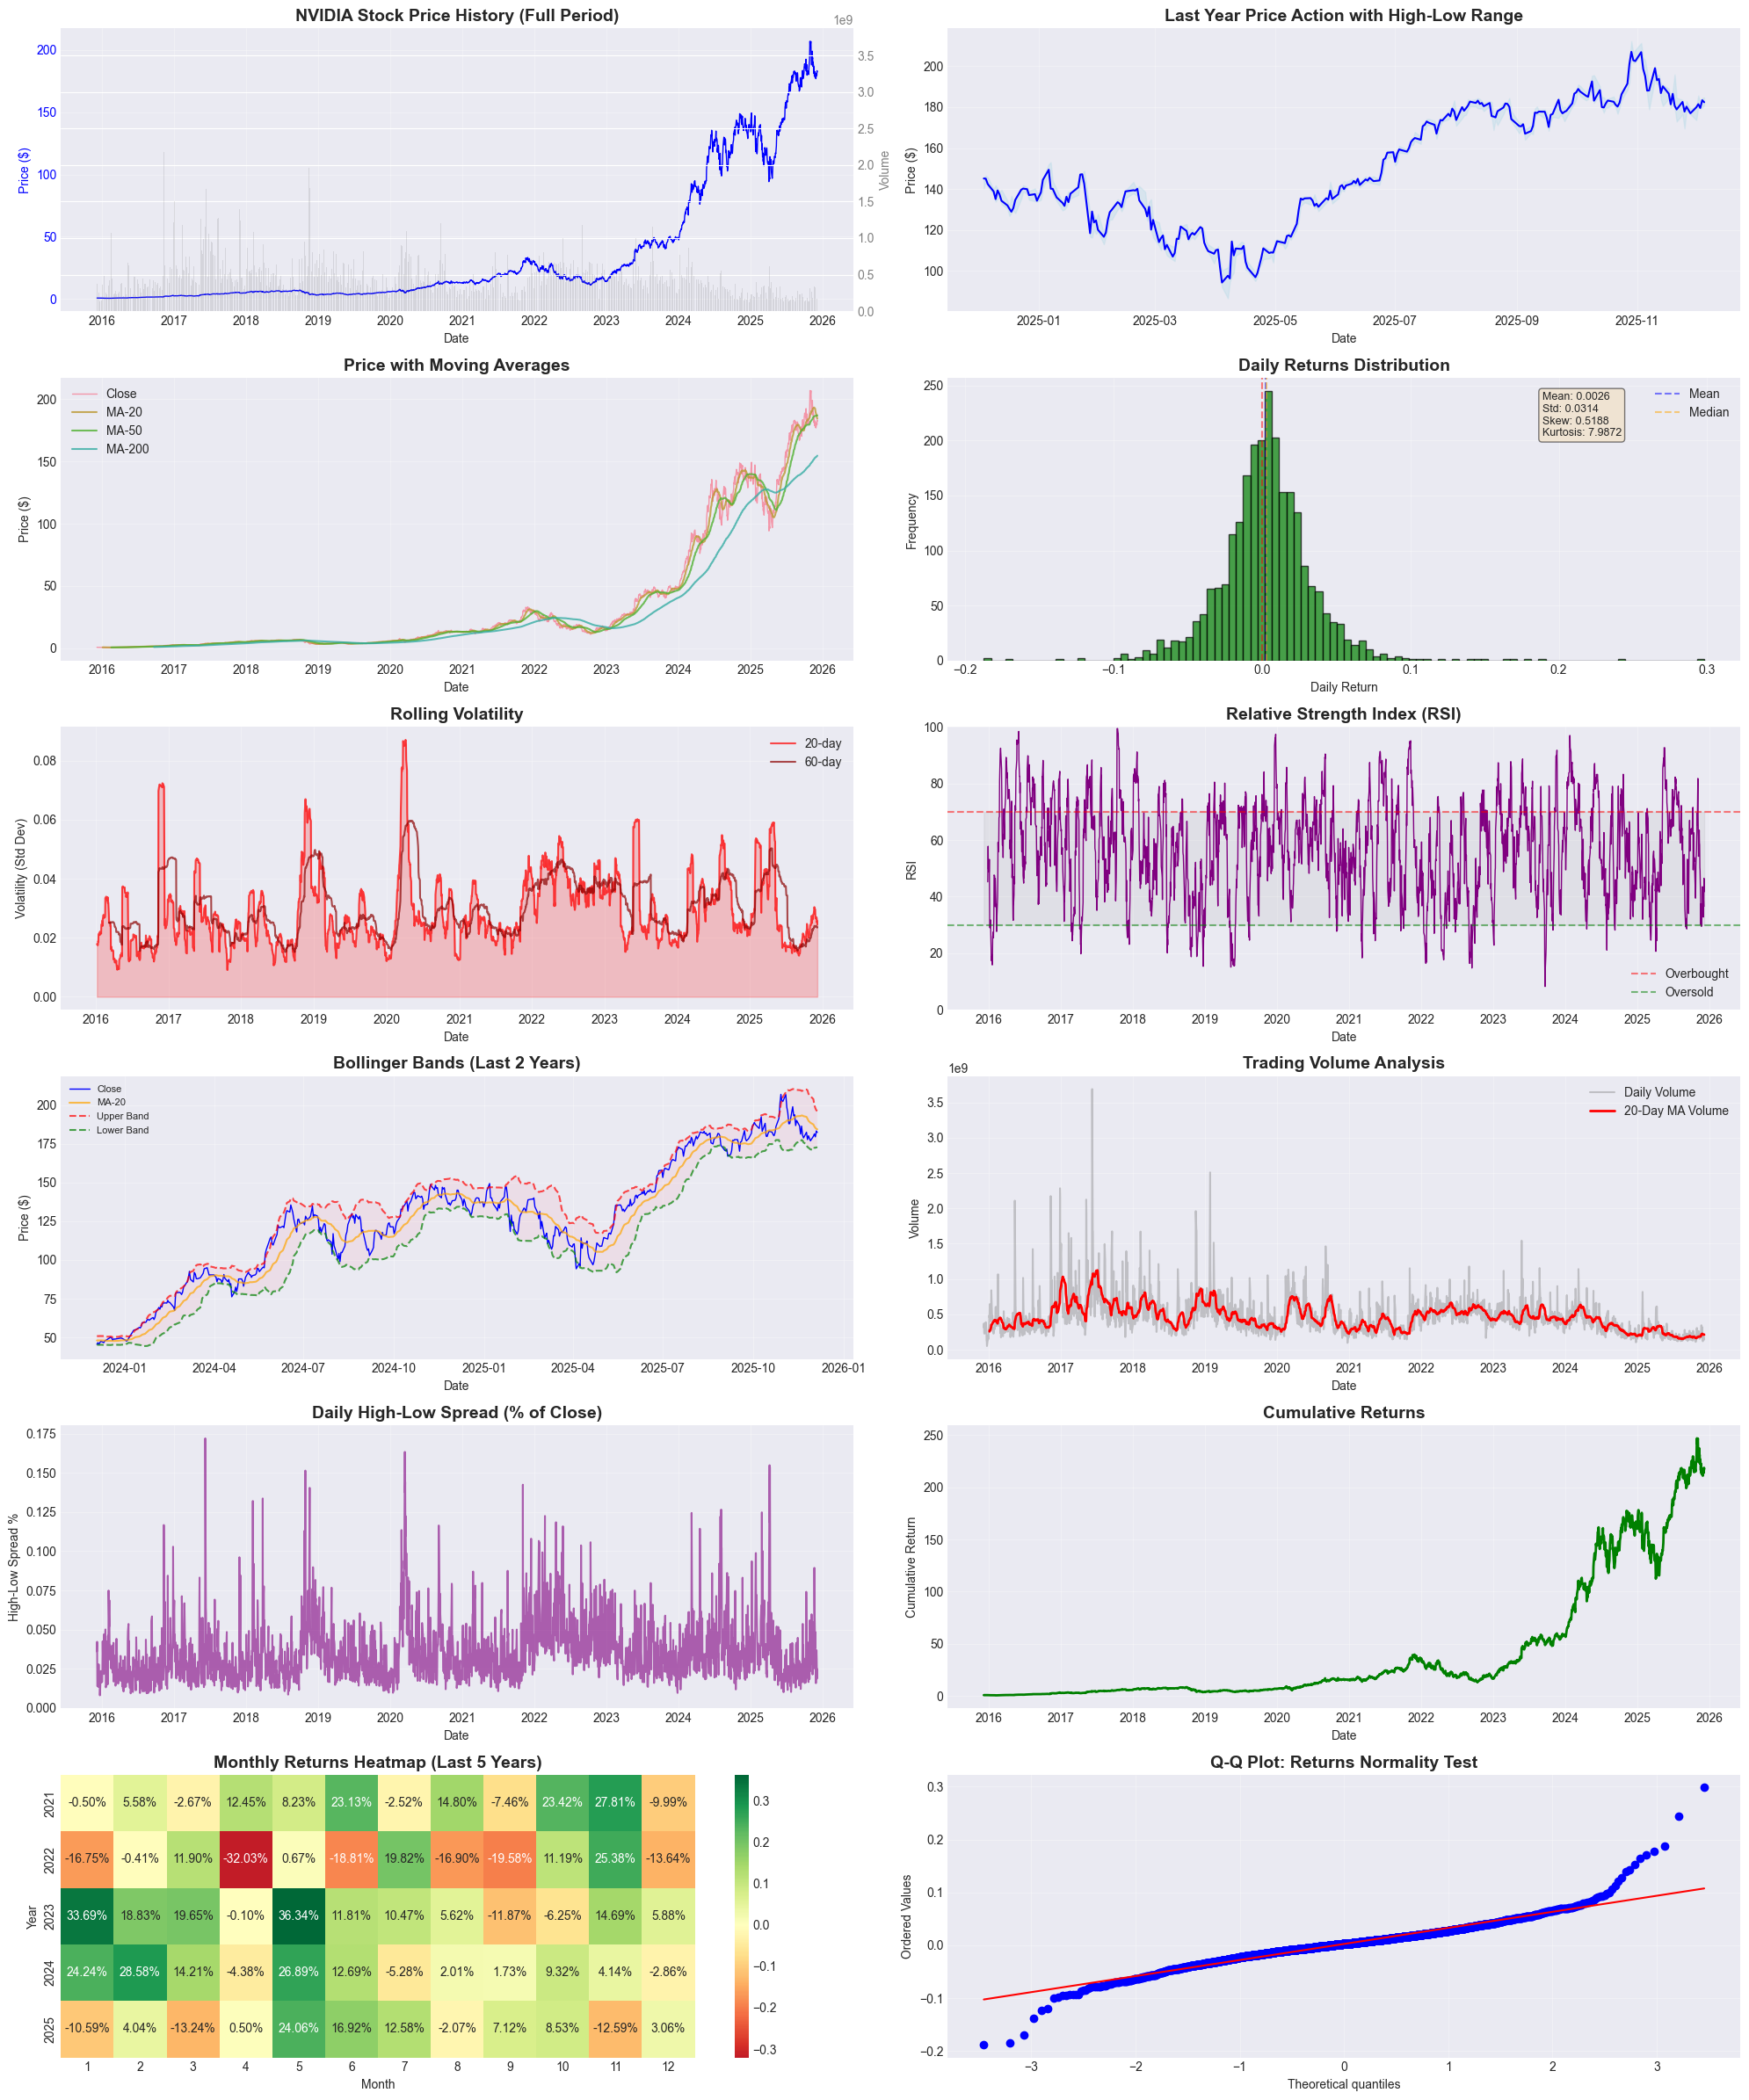


NVIDIA STOCK SUMMARY STATISTICS
Total Trading Days: 2514
Date Range: 2015-12-08 to 2025-12-05
Current Price: $182.41
52-Week High: $207.04
52-Week Low: $94.31
Average Daily Return: 0.2633%
Volatility (Annual): 49.8607%
Sharpe Ratio: 1.3306


In [4]:
fig = plt.figure(figsize=(20, 24))

# 1. Price history with volume
ax1 = plt.subplot(6, 2, 1)
ax1.plot(df_clean.index, df_clean['Close/Last'], label='Close Price', color='blue', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('NVIDIA Stock Price History (Full Period)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add volume on secondary axis
ax1_vol = ax1.twinx()
ax1_vol.bar(df_clean.index, df_clean['Volume'], alpha=0.2, color='gray', width=1)
ax1_vol.set_ylabel('Volume', color='gray')
ax1_vol.tick_params(axis='y', labelcolor='gray')

# 2. Recent price action (last year)
ax2 = plt.subplot(6, 2, 2)
recent_year = df_clean.iloc[-252:]  # Last trading year
ax2.plot(recent_year.index, recent_year['Close/Last'], label='Close', color='blue', linewidth=1.5)
ax2.fill_between(recent_year.index, recent_year['Low'], recent_year['High'], alpha=0.3, color='lightblue')
ax2.set_title('Last Year Price Action with High-Low Range', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.grid(True, alpha=0.3)

# 3. Price with Moving Averages
ax3 = plt.subplot(6, 2, 3)
ax3.plot(df_clean.index, df_clean['Close/Last'], label='Close', alpha=0.7, linewidth=1)
ax3.plot(df_clean.index, df_clean['MA_20'], label='MA-20', alpha=0.8)
ax3.plot(df_clean.index, df_clean['MA_50'], label='MA-50', alpha=0.8)
ax3.plot(df_clean.index, df_clean['MA_200'], label='MA-200', alpha=0.8)
ax3.set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Price ($)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# 4. Daily Returns Distribution
ax4 = plt.subplot(6, 2, 4)
returns = df_clean['Daily_Return'].dropna()
ax4.hist(returns, bins=100, edgecolor='black', alpha=0.7, color='green')
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax4.axvline(x=returns.mean(), color='blue', linestyle='--', alpha=0.5, label='Mean')
ax4.axvline(x=returns.median(), color='orange', linestyle='--', alpha=0.5, label='Median')
ax4.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Daily Return')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"Mean: {returns.mean():.4f}\nStd: {returns.std():.4f}\nSkew: {returns.skew():.4f}\nKurtosis: {returns.kurtosis():.4f}"
ax4.text(0.75, 0.95, stats_text, transform=ax4.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Rolling Volatility (20-day and 60-day)
ax5 = plt.subplot(6, 2, 5)
ax5.plot(df_clean.index, df_clean['Volatility'], color='red', alpha=0.7, label='20-day')
ax5.plot(df_clean.index, df_clean['Daily_Return'].rolling(60).std(), color='darkred', alpha=0.7, label='60-day')
ax5.fill_between(df_clean.index, 0, df_clean['Volatility'], color='red', alpha=0.2)
ax5.set_title('Rolling Volatility', fontsize=14, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Volatility (Std Dev)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. RSI Indicator
ax6 = plt.subplot(6, 2, 6)
ax6.plot(df_clean.index, df_clean['RSI'], color='purple', linewidth=1)
ax6.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought')
ax6.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold')
ax6.fill_between(df_clean.index, 30, 70, alpha=0.1, color='gray')
ax6.set_title('Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date')
ax6.set_ylabel('RSI')
ax6.set_ylim(0, 100)
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Bollinger Bands
ax7 = plt.subplot(6, 2, 7)
recent_period = df_clean.iloc[-504:]  # Last 2 years
ax7.plot(recent_period.index, recent_period['Close/Last'], label='Close', color='blue', linewidth=1)
ax7.plot(recent_period.index, recent_period['MA_20'], label='MA-20', color='orange', alpha=0.7)
ax7.plot(recent_period.index, recent_period['Upper_Band'], label='Upper Band', color='red', linestyle='--', alpha=0.7)
ax7.plot(recent_period.index, recent_period['Lower_Band'], label='Lower Band', color='green', linestyle='--', alpha=0.7)
ax7.fill_between(recent_period.index, recent_period['Upper_Band'], recent_period['Lower_Band'], alpha=0.1)
ax7.set_title('Bollinger Bands (Last 2 Years)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('Price ($)')
ax7.legend(loc='best', fontsize=8)
ax7.grid(True, alpha=0.3)

# 8. Volume Analysis
ax8 = plt.subplot(6, 2, 8)
ax8.plot(df_clean.index, df_clean['Volume'], alpha=0.4, label='Daily Volume', color='gray')
ax8.plot(df_clean.index, df_clean['Volume_MA'], color='red', label='20-Day MA Volume', linewidth=2)
ax8.set_title('Trading Volume Analysis', fontsize=14, fontweight='bold')
ax8.set_xlabel('Date')
ax8.set_ylabel('Volume')
ax8.legend(loc='best')
ax8.grid(True, alpha=0.3)

# 9. High-Low Spread (Volatility Proxy)
ax9 = plt.subplot(6, 2, 9)
ax9.plot(df_clean.index, df_clean['High_Low_Pct'], color='purple', alpha=0.6)
ax9.set_title('Daily High-Low Spread (% of Close)', fontsize=14, fontweight='bold')
ax9.set_xlabel('Date')
ax9.set_ylabel('High-Low Spread %')
ax9.grid(True, alpha=0.3)

# 10. Cumulative Returns
ax10 = plt.subplot(6, 2, 10)
cumulative_returns = (1 + df_clean['Daily_Return']).cumprod()
ax10.plot(df_clean.index, cumulative_returns, color='green', linewidth=2)
ax10.set_title('Cumulative Returns', fontsize=14, fontweight='bold')
ax10.set_xlabel('Date')
ax10.set_ylabel('Cumulative Return')
ax10.grid(True, alpha=0.3)

# 11. Monthly Returns Heatmap Data Prep
ax11 = plt.subplot(6, 2, 11)
df_clean['Year'] = df_clean.index.year
df_clean['Month'] = df_clean.index.month
monthly_returns = df_clean.groupby(['Year', 'Month'])['Daily_Return'].apply(lambda x: (1 + x).prod() - 1)
monthly_returns_pivot = monthly_returns.unstack()
sns.heatmap(monthly_returns_pivot.iloc[-5:], annot=True, fmt='.2%', cmap='RdYlGn', center=0, ax=ax11)
ax11.set_title('Monthly Returns Heatmap (Last 5 Years)', fontsize=14, fontweight='bold')

# 12. Q-Q Plot for Returns Normality
from scipy import stats
ax12 = plt.subplot(6, 2, 12)
stats.probplot(returns, dist="norm", plot=ax12)
ax12.set_title('Q-Q Plot: Returns Normality Test', fontsize=14, fontweight='bold')
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("NVIDIA STOCK SUMMARY STATISTICS")
print("="*60)
print(f"Total Trading Days: {len(df_clean)}")
print(f"Date Range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")
print(f"Current Price: ${df_clean['Close/Last'].iloc[-1]:.2f}")
print(f"52-Week High: ${df_clean['Close/Last'].iloc[-252:].max():.2f}")
print(f"52-Week Low: ${df_clean['Close/Last'].iloc[-252:].min():.2f}")
print(f"Average Daily Return: {df_clean['Daily_Return'].mean():.4%}")
print(f"Volatility (Annual): {df_clean['Daily_Return'].std() * np.sqrt(252):.4%}")
print(f"Sharpe Ratio: {(df_clean['Daily_Return'].mean() / df_clean['Daily_Return'].std()) * np.sqrt(252):.4f}")